In [170]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data and calculate GF

In [171]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [172]:
A = utils.find_area(ds_out)/1e3 #convert to m

In [173]:
ds_control, ds_pulse, G =  utils.import_regrid_calc('cmip6_data/co2mass_Amon_GFDL-ESM4_esm-piControl*', 
                         'cmip6_data/co2mass_Amon_GFDL-ESM4_esm-pi-CO2pulse_r1i1p1f1_gn_010101-020012.nc', 
                         ds_out, 'co2mass', pulse_size = 100, replace_xy = False, regrid = False) # 100GtC/kg

In [174]:
## import a second CO2 response based on Joos

In [175]:
rcp_85_response = pd.read_csv('Joos_8.5_RCP.csv', header = None, index_col = 0)

In [176]:
rcp_85_ds = xr.Dataset(data_vars = dict(co2_response = (['year'], rcp_85_response[1].values)),
            #dims = ['time'],
            coords = dict(year = ('year', rcp_85_response.index))
            )

In [177]:
rcp_85_ds = rcp_85_ds.interp(year = np.arange(1,101,1), method = 'linear')

In [178]:
rcp_85_ds['co2_response'] = rcp_85_ds['co2_response']*G[0]

In [179]:
rcp_85_ds['year'] = G['year']

In [180]:
rcp_85_ds['co2_response'][0] = G[0]

In [181]:
##import co2 fluxes to calculate emissions from cdrmip run

In [182]:
fg_co2_pulse_ds = xr.open_mfdataset('cmip6_data/fgco2_Omon_GFDL-ESM4_1pct*')
nbp_pulse_ds = xr.open_mfdataset('cmip6_data/nbp_Lmon_GFDL-ESM4_1pct*')

In [183]:
fg_co2_pictrl_ds = xr.open_mfdataset('cmip6_data/fgco2_Omon_GFDL-ESM4_esm-pi*')
nbp_pictrl_ds = xr.open_mfdataset('cmip6_data/nbp_Lmon_GFDL-ESM4_esm-pi*')

In [184]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [185]:
fg_co2_pulse_ds = utils._regrid_ds(fg_co2_pulse_ds, ds_out)
nbp_pulse_ds = utils._regrid_ds(nbp_pulse_ds, ds_out)

fg_co2_pictrl_ds = utils._regrid_ds(fg_co2_pictrl_ds, ds_out)
nbp_pictrl_ds = utils._regrid_ds(nbp_pictrl_ds, ds_out)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter 

In [186]:
seconds_per_year = 3.154e+7

In [187]:
fg_co2_ds = fg_co2_pulse_ds - fg_co2_pictrl_ds
nbp_ds = nbp_pulse_ds - nbp_pictrl_ds

In [188]:
fg_co2_ds['fgco2'] = fg_co2_ds['fgco2']*A*seconds_per_year
nbp_ds['nbp'] = nbp_ds['nbp']*A*seconds_per_year

## Concentration response

(0.0, 3489907815219.2)

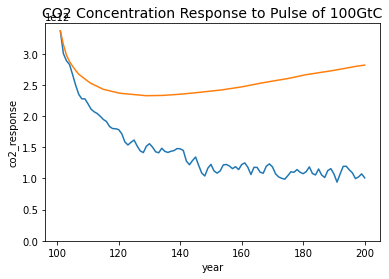

In [189]:
G.plot()
rcp_85_ds['co2_response'].plot()
plt.title('CO2 Concentration Response to Pulse of 100GtC', fontsize = 14)
plt.ylim(0,None)

## Create a compounding concentration profile

In [190]:
init_co2 = 2.21718909e+15 #estimated from initial co2 mass above from control ***need to fix*** #284.3 #ppm https://gmd.copernicus.org/articles/10/2057/2017/
pct_increase = 0.01
years_increase = 99
co2_arr = utils.compound_mult(init_co2, years_increase, pct_increase) - init_co2 ## add this on np.ones(100)*init_co2 ##remove init_co2 from arry so it is 1
#co2_arr = np.concatenate((np.ones(100)*init_co2, co2_arr))
#co2_arr = np.concatenate((co2_arr, np.ones(10)*co2_arr[-1]))
##stops at 140 bc quadrupling

Text(0.5, 1.0, '1pct Increase in CO2 Concentration until 4x')

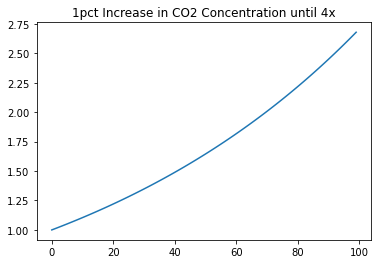

In [191]:
plt.plot((co2_arr + init_co2)/init_co2)
plt.title('1pct Increase in CO2 Concentration until 4x')

## calculate the first emissions time-step

In [192]:
def calc_emis_fit_1pct(G, co2_arr):
    '''Calculate an emissions profile that fits our 1pct increase in concentration by convolving a CO2 concentration 
    response to emissions Green's function with the initial emissions, summing, and backing out our emissions step by step'''
    E = {}
    conv_out = {}
    conv_sum = {}
    ## kg/(kg/GtC) --> GtC Units
    #calculate emissions from our first time step
    E[0] = co2_arr[0]/G[0].values
    #calculate our second timestep
    conv_out[0] = signal.convolve(np.array(G), E[0][..., None], mode = 'same')
    E[1] = (co2_arr[1]-conv_out[0][1])/G[0].values
    #create a sum of our convolution
    conv_sum[1] = conv_out[0]
    #loop across our time range
    for i in np.arange(2,100):
       # print(i)
        #print(signal.convolve(np.array(G), E[i-1][..., None], mode = 'same'))
        conv_out[i-1] = signal.convolve(np.array(G), E[i-1][..., None], mode = 'same')
        #print(np.append(np.zeros(i),conv_out[i-1][:-i]).shape)
        conv_sum[i] = conv_sum[i-1] + np.append(np.zeros(i),conv_out[i-1][:-i])
        #print(conv_sum[i-1])
        E[i] = (co2_arr - conv_sum[i])[i]/G[0].values
        #print(E[i])
    return(E)

In [193]:
E_base = calc_emis_fit_1pct(G, co2_arr)

In [194]:
E_85 = calc_emis_fit_1pct(rcp_85_ds.co2_response, co2_arr)

In [195]:
conv_base = signal.convolve(np.array(G), np.array(list(E_base.values())), mode = 'full')
conv_rcp85 = signal.convolve(np.array(rcp_85_ds.co2_response), np.array(list(E_85.values())), mode = 'full')

(0.0, 100.0)

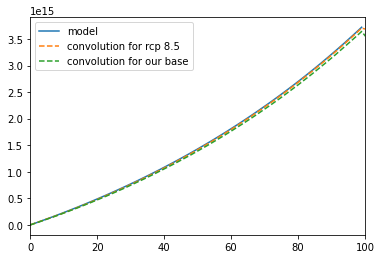

In [196]:
plt.plot(co2_arr, label = 'model')
plt.plot(conv_rcp85, label = 'convolution for rcp 8.5', linestyle = '--')
plt.plot(conv_base, label = 'convolution for our base', linestyle = '--')
plt.legend()
plt.xlim(0,100)
#plt.ylim(0,4e15)

## calculate emissions according to liddicoat et al. 2021

emis_co2_ds = co2_atm_ds['co2mass'] + fg_co2_ds['fgco2'] + nbp_ds['nbp']

GtC_per_ppm = 2.124 #GtC/ppm estimated from Ballantyne et al 2015
GtC_per_kgC = 10e12

In [197]:
G_atm_1pct = ((utils.compound_mult(init_co2, years_increase, pct_increase)) - init_co2)#[...,None, None]

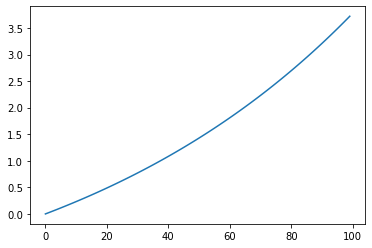

In [198]:
plt.plot(G_atm_1pct/1e15)

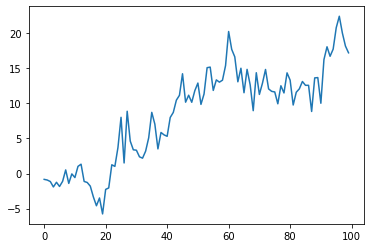

In [199]:
plt.plot(fg_co2_ds['fgco2'].isel(time = slice(0,len(co2_arr))).weighted(A).mean(dim = ['lat','lon']))

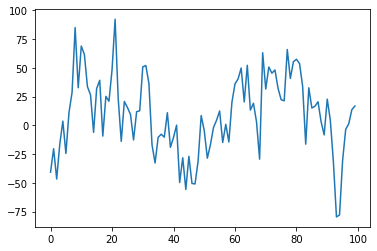

In [200]:
plt.plot(nbp_ds['nbp'].isel(time = slice(0,len(co2_arr))).weighted(A).mean(dim = ['lat','lon']))

In [201]:
emis_co2_ds =  (G_atm_1pct/1e15)[...,None,None] + fg_co2_ds['fgco2'].isel(time = slice(0,len(co2_arr))) + nbp_ds['nbp'].isel(time = slice(0,len(co2_arr)))

In [202]:
emis_co2_liddicoat_ds = emis_co2_ds.weighted(A).mean(dim = ['lat','lon'])

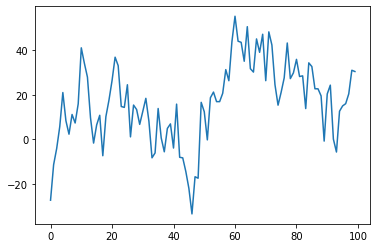

In [203]:
plt.plot(emis_co2_liddicoat_ds) #GtC/yr

# Save out CO2 emissions

In [204]:
np.savetxt('1pct_emis_profile_derived.csv', np.array(list(E_base.values())), delimiter=',')
np.savetxt('1pct_emis_profile_rcp85.csv', np.array(list(E_85.values())), delimiter=',')
np.savetxt('1pct_emis_profile_sinks.csv', np.array(emis_co2_liddicoat_ds))